## Sparse Gaussian Processをやってみる


In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix

In [3]:
true_func = lambda x:(np.sign(x) + 1)/2 * x * np.sin(x) + (np.sign(-x) + 1)/2 * np.exp(-x**2)

In [4]:
n = 1000
N = 100
data_seed = 20190701

In [5]:
### データ生成
np.random.seed(data_seed)
domain_X = (-5, 5)
M = 1
train_X = np.random.uniform(low = domain_X[0], high = domain_X[1], size = (n, M))
test_X = np.random.uniform(low = domain_X[0], high = domain_X[1], size = (N, M))
train_Y = (true_func(train_X) + np.random.normal(size = (n, M))).squeeze()
test_Y = (true_func(test_X) + np.random.normal(size = (N, M))).squeeze()

In [18]:
def det_subsampling(x:np.ndarray, y:np.ndarray, sub_n:int = 10, seed = -1) -> (np.ndarray, np.ndarray, np.ndarray):
    if seed > 0:
        np.random.seed(seed)
    if sub_n > x.shape[0]:
        raise ValueError("Invalid sample number for sub_n! sub_n should be less than total sample number")
    
    sub_ind = np.argsort(np.random.dirichlet(np.ones(x.shape[0])))[:sub_n]
    
    if x.ndim == 1:
        return(sub_ind, x[sub_ind], y[sub_ind])
    else:
        return(sub_ind, x[sub_ind, :], y[sub_ind])

In [34]:
### 学習部分の設定
learning_seed = 20190703
sug_n = 10
theta1 = 1; theta2 = 0.5; ln_sigma = 1
gauss_kernel = lambda x, y, theta1, theta2: theta1 * np.exp(- theta2 * distance_matrix(x,y, p=2)/2)
gauss_kernel_diag = lambda x,theta1,theta2: theta1

used_kernel = gauss_kernel
used_kernel_diag = gauss_kernel_diag

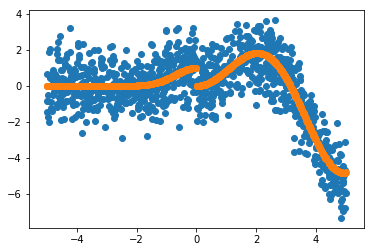

In [20]:
plt.scatter(train_X, train_Y)
plt.scatter(train_X, true_func(train_X))
plt.show()

In [23]:
(sub_ind, sub_X, sub_Y) = det_subsampling(train_X, train_Y, sug_n, learning_seed)

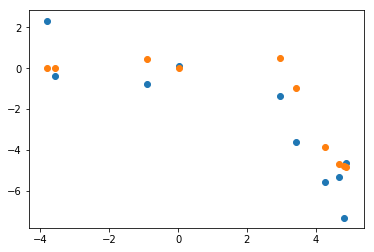

In [24]:
plt.scatter(sub_X, sub_Y)
plt.scatter(sub_X, true_func(sub_X))
plt.show()

In [29]:
sub_train_kernel = used_kernel(sub_X, train_X, theta1, theta2)
sub_sub_kernel = used_kernel(sub_X, sub_X, theta1, theta2)
inv_sub_sub_kernel = np.linalg.inv(sub_sub_kernel)
train_kernel_diag = used_kernel_diag(train_X, theta1, theta2)

In [63]:
prior_var = train_kernel_diag - (sub_train_kernel * (inv_sub_sub_kernel @ sub_train_kernel)).sum(axis=0)
var_yu = prior_var + ln_sigma
inv_var_yu = 1/var_yu

Q = sub_sub_kernel + np.einsum("ik, jk, k -> ij", sub_train_kernel, sub_train_kernel, inv_var_yu)
inv_Q = np.linalg.inv(Q)

est_cov = sub_sub_kernel @ inv_Q @ sub_sub_kernel
est_inv_cov = inv_sub_sub_kernel @ Q @ inv_sub_sub_kernel

est_u = sub_sub_kernel @ inv_Q @ sub_train_kernel @ (inv_var_yu * train_Y)

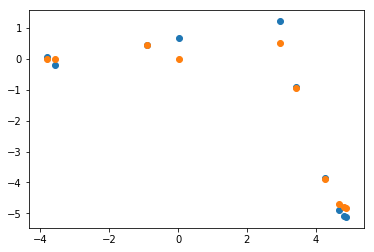

In [57]:
plt.scatter(sub_train_X, est_u)
plt.scatter(sub_train_X, true_func(sub_train_X))

## 予測する

In [69]:
test_sub_kernel = used_kernel(test_X, sub_train_X, theta1, theta2)
test_kernel_diag = used_kernel_diag(test_X, theta1, theta2)

pred_mean_Y = test_sub_kernel @ inv_sub_sub_kernel @ est_u
pred_var_Y = test_kernel_diag - (test_sub_kernel * (test_sub_kernel @ est_inv_cov)).sum(axis = 0)

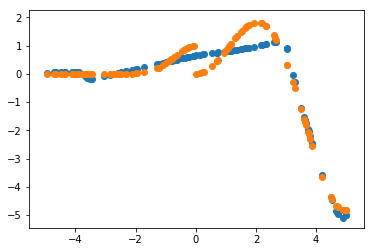

In [71]:
plt.scatter(test_X, pred_mean_Y)
plt.scatter(test_X, true_func(test_X))
plt.show()